#Before starting:
* This notebook is meant to run on Google Colaboratory;
* It requires you to download a third party software, otherwise it will not run. (I know it's tedious but I don't own the program and so I can't share it with you);
* I suggest to use an environment with a GPU.


##Preliminaries

###Install 'tensorflow-model-optimization' for Quantization Aware Training (QAT)

In [ ]:
!pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 59.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.

###Get 'stm32tflm' software

* Download 'X-CUBE-AI-Linux' package from https://www.st.com/en/embedded-software/x-cube-ai.html;
* Extract the 'stm32tflm' executable from the downloaded package;
* Put it in the folder you're working (usually '/content/' for Google Colaboratory).

Enable the execution of the 'stm32tflm' program

In [ ]:
!git clone https://github.com/AndreaMattiaGaravagno/ColabNAS

Cloning into 'ColabNAS'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 56 (delta 23), reused 11 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 463.65 KiB | 4.29 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
!chmod +x /content/ColabNAS/stm32tflm

In [ ]:
mv /content/ColabNAS/stm32tflm /content/

In [ ]:
!pip install --upgrade numpy==2.0.0

##ColabNAS code

In [ ]:
from tensorflow_model_optimization.python.core.keras.compat import keras
from pathlib import Path
import tensorflow as tf
import numpy as np
import subprocess
import datetime
import shutil
import glob
import re
import os

class ColabNAS :
    architecture_name = 'resulting_architecture'
    def __init__(self, max_RAM, max_Flash, max_MACC, path_to_training_set, val_split, cache=False, input_shape=(50,50,3), save_path='.', path_to_stm32tflm='/content/stm32tflm') :
        self.learning_rate = 1e-3
        self.batch_size = 128
        self.epochs = 100 #minimum 2

        self.max_MACC = max_MACC
        self.max_Flash = max_Flash
        self.max_RAM = max_RAM
        self.path_to_training_set = path_to_training_set
        self.num_classes = len(next(os.walk(path_to_training_set))[1])
        self.val_split = val_split
        self.cache = cache
        self.input_shape = input_shape
        self.save_path = Path(save_path)

        self.path_to_trained_models = self.save_path / "trained_models"
        self.path_to_trained_models.mkdir(parents=True)

        self.path_to_stm32tflm = Path(path_to_stm32tflm)

        self.load_training_set()

    # k number of kernels of the first convolutional layer
    # c number of cells added upon the first convolutional layer
    # pre-processing pipeline not included in MACC computation
    def Model(self, k, c) :
        kernel_size = (3,3)
        pool_size = (2,2)
        pool_strides = (2,2)

        number_of_cells_limited = False
        number_of_mac = 0

        inputs = keras.Input(shape=self.input_shape)

        #convolutional base
        n = int(k)
        multiplier = 2

        #first convolutional layer
        c_in = self.input_shape[2]
        x = keras.layers.Conv2D(n, kernel_size, padding='same')(inputs)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

        number_of_mac = number_of_mac + (c_in * kernel_size[0] * kernel_size[1] * x.shape[1] * x.shape[2] * x.shape[3])

        #adding cells
        for i in range(1, c + 1) :
            if x.shape[1] <= 1 or x.shape[2] <= 1 :
                number_of_cells_limited = True
                break;
            n = int(np.ceil(n * multiplier))
            multiplier = multiplier - 2**-i
            x = keras.layers.MaxPooling2D(pool_size=pool_size, strides=pool_strides, padding='valid')(x)
            c_in = x.shape[3]
            x = keras.layers.Conv2D(n, kernel_size, padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
            number_of_mac = number_of_mac + (c_in * kernel_size[0] * kernel_size[1] * x.shape[1] * x.shape[2] * x.shape[3])

        #classifier
        x = keras.layers.GlobalAveragePooling2D()(x)
        input_shape = x.shape[1]
        x = keras.layers.Dense(n)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
        number_of_mac = number_of_mac + (input_shape * x.shape[1])
        x = keras.layers.Dense(self.num_classes)(x)
        x = keras.layers.BatchNormalization()(x)
        outputs = keras.layers.Softmax()(x)
        number_of_mac = number_of_mac + (x.shape[1] * outputs.shape[1])

        model = keras.Model(inputs=inputs, outputs=outputs)

        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

        model.summary()

        return model, number_of_mac, number_of_cells_limited

    def load_training_set(self):
        if 3 == self.input_shape[2] :
            color_mode = 'rgb'
        elif 1 == self.input_shape[2] :
            color_mode = 'grayscale'

        train_ds = tf.keras.utils.image_dataset_from_directory(
            directory= self.path_to_training_set,
            labels='inferred',
            label_mode='categorical',
            color_mode=color_mode,
            batch_size=self.batch_size,
            image_size=self.input_shape[0:2],
            shuffle=True,
            seed=11,
            validation_split=self.val_split,
            subset='training'
        )

        validation_ds = tf.keras.utils.image_dataset_from_directory(
            directory= self.path_to_training_set,
            labels='inferred',
            label_mode='categorical',
            color_mode=color_mode,
            batch_size=self.batch_size,
            image_size=self.input_shape[0:2],
            shuffle=True,
            seed=11,
            validation_split=self.val_split,
            subset='validation'
        )

        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.2, fill_mode='constant', interpolation='bilinear'),
            #tf.keras.layers.Rescaling(1./255)
            ])

        if self.cache :
            self.train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
            self.validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        else :
            self.train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
            self.validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    def quantize_model_uint8(self) :
        def representative_dataset():
            for data in self.train_ds.rebatch(1).take(150) :
                yield [tf.dtypes.cast(data[0], tf.float32)]

        model = tf.keras.models.load_model(self.path_to_trained_models / f"{self.model_name}.h5")
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
        tflite_quant_model = converter.convert()

        with open(self.path_to_trained_models / f"{self.model_name}.tflite", 'wb') as f:
            f.write(tflite_quant_model)

        (self.path_to_trained_models / f"{self.model_name}.h5").unlink()

    def evaluate_flash_and_peak_RAM_occupancy(self) :
        #quantize model to evaluate its peak RAM occupancy and its Flash occupancy
        self.quantize_model_uint8()

        #evaluate its peak RAM occupancy and its Flash occupancy using STMicroelectronics' X-CUBE-AI
        proc = subprocess.Popen([self.path_to_stm32tflm, self.path_to_trained_models / f"{self.model_name}.tflite"], stdout=subprocess.PIPE)
        try:
            outs, errs = proc.communicate(timeout=15)
            Flash, RAM = re.findall(r'\d+', str(outs))
        except subprocess.TimeoutExpired:
            proc.kill()
            outs, errs = proc.communicate()
            print("stm32tflm error")
            exit()

        return int(Flash), int(RAM)

    def evaluate_model_process(self, k, c) :
        if k > 0 :
            self.model_name = f"k_{k}_c_{c}"
            print(f"\n{self.model_name}\n")
            checkpoint = tf.keras.callbacks.ModelCheckpoint(
                str(self.path_to_trained_models / f"{self.model_name}.h5"), monitor='val_accuracy',
                verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
            model, MACC, number_of_cells_limited = self.Model(k, c)
            #One epoch of training must be done before quantization, which is needed to evaluate RAM and Flash occupancy
            model.fit(self.train_ds, epochs=1, validation_data=self.validation_ds, validation_freq=1)
            model.save(self.path_to_trained_models / f"{self.model_name}.h5")
            Flash, RAM = self.evaluate_flash_and_peak_RAM_occupancy()
            print(f"\nRAM: {RAM},\t Flash: {Flash},\t MACC: {MACC}\n")
            if MACC <= self.max_MACC and Flash <= self.max_Flash and RAM <= self.max_RAM and not number_of_cells_limited :
                hist = model.fit(self.train_ds, epochs=self.epochs - 1, validation_data=self.validation_ds, validation_freq=1, callbacks=[checkpoint])
                self.quantize_model_uint8()
            return {'k': k,
                    'c': c if not number_of_cells_limited else "Not feasible",
                    'RAM': RAM if RAM <= self.max_RAM else "Outside the upper bound",
                    'Flash': Flash if Flash <= self.max_Flash else "Outside the upper bound",
                    'MACC': MACC if MACC <= self.max_MACC else "Outside the upper bound",
                    'max_val_acc':
                    np.around(np.amax(hist.history['val_accuracy']), decimals=3)
                    if 'hist' in locals() else -3}
        else :
            return{'k': 'unfeasible', 'c': c, 'max_val_acc': -3}

    def explore_num_cells(self, k) :
        previous_architecture = {'k': -1, 'c': -1, 'max_val_acc': -2}
        current_architecture = {'k': -1, 'c': -1, 'max_val_acc': -1}
        c = -1
        k = int(k)

        while(current_architecture['max_val_acc'] > previous_architecture['max_val_acc']) :
            previous_architecture = current_architecture
            c = c + 1
            self.model_counter = self.model_counter + 1
            current_architecture = self.evaluate_model_process(k, c)
            print(f"\n\n\n{current_architecture}\n\n\n")
        return previous_architecture

    def search(self) :
        self.model_counter = 0
        epsilon = 0.005
        k0 = 4

        start = datetime.datetime.now()

        k = k0
        previous_architecture = self.explore_num_cells(k)
        k = 2 * k
        current_architecture = self.explore_num_cells(k)

        if (current_architecture['max_val_acc'] > previous_architecture['max_val_acc']) :
            previous_architecture = current_architecture
            k = 2 * k
            current_architecture = self.explore_num_cells(k)
            while(current_architecture['max_val_acc'] > previous_architecture['max_val_acc'] + epsilon) :
                previous_architecture = current_architecture
                k = 2 * k
                current_architecture = self.explore_num_cells(k)
        else :
            k = k0 / 2
            current_architecture = self.explore_num_cells(k)
            while(current_architecture['max_val_acc'] >= previous_architecture['max_val_acc']) :
                previous_architecture = current_architecture
                k = k / 2
                current_architecture = self.explore_num_cells(k)

        resulting_architecture = previous_architecture

        end = datetime.datetime.now()

        if (resulting_architecture['max_val_acc'] > 0) :
            resulting_architecture_name = f"k_{resulting_architecture['k']}_c_{resulting_architecture['c']}.tflite"
            self.path_to_resulting_architecture = self.save_path / f"resulting_architecture_{resulting_architecture_name}"
            (self.path_to_trained_models / f"{resulting_architecture_name}").rename(self.path_to_resulting_architecture)
            shutil.rmtree(self.path_to_trained_models)
            print(f"\nResulting architecture: {resulting_architecture}\n")
        else :
            print(f"\nNo feasible architecture found\n")
        print(f"Elapsed time (search): {end-start}\n")

        return self.path_to_resulting_architecture

##Try ColabNAS!

###download a small dataset

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 6s 0us/step


In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

###Run HW-NAS
target: STM32L412KBU3 (273 CoreMark, 40 kiB RAM, 128 kiB Flash)

In [ ]:
import numpy as np
import tensorflow as tf

input_shape = (50,50,3)

#target: STM32L412KBU3
#273 CoreMark, 40 kiB RAM, 128 kiB Flash
peak_RAM_upper_bound = 40960
Flash_upper_bound = 131072
MACC_upper_bound = 2730000 #CoreMark * 1e4

#Each dataset must comply with the following structure
#main_directory/
#...class_a/
#......a_image_1.jpg
#......a_image_2.jpg
#...class_b/
#......b_image_1.jpg
#......b_image_2.jpg
path_to_training_set = data_dir
val_split = 0.3

#whether or not to cache datasets in memory
#if the dataset cannot fit in the main memory, the application will crash
cache = True

#where to save results
save_path = '/content/'

#to show the GPU used
!nvidia-smi

colabNAS = ColabNAS(peak_RAM_upper_bound, Flash_upper_bound, MACC_upper_bound, path_to_training_set, val_split, cache, input_shape, save_path=save_path)

#search
path_to_tflite_model = colabNAS.search()

Sun Jan  4 15:08:57 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 19968,	 Flash: 3832,	 MACC: 270041

Epoch 1/99
15/21 [====================>.........] - ETA: 0s - loss: 1.8880 - accuracy: 0.1990
Epoch 1: val_accuracy improved from -inf to 0.26975, saving model to /content/trained_models/k_4_c_0.h5
21/21 [==============================] - 0s 11ms/step - loss: 1.8815 - accuracy: 0.2024 - val_loss: 1.6012 - val_accuracy: 0.2698
Epoch 2/99
14/21 [===================>..........] - ETA: 0s - loss: 1.8283 - accuracy: 0.2182

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.26975 to 0.29064, saving model to /content/trained_models/k_4_c_0.h5
21/21 [==============================] - 0s 12ms/step - loss: 1.8203 - accuracy: 0.2289 - val_loss: 1.6054 - val_accuracy: 0.2906
Epoch 3/99
16/21 [=====================>........] - ETA: 0s - loss: 1.7625 - accuracy: 0.2559
Epoch 3: val_accuracy improved from 0.29064 to 0.29973, saving model to /content/trained_models/k_4_c_0.h5
21/21 [==============================] - 0s 11ms/step - loss: 1.7620 - accuracy: 0.2581 - val_loss: 1.6069 - val_accuracy: 0.2997
Epoch 4/99
15/21 [====================>.........] - ETA: 0s - loss: 1.7145 - accuracy: 0.2708
Epoch 4: val_accuracy did not improve from 0.29973
21/21 [==============================] - 0s 9ms/step - loss: 1.7129 - accuracy: 0.2736 - val_loss: 1.5962 - val_accuracy: 0.2997
Epoch 5/99
15/21 [====================>.........] - ETA: 0s - loss: 1.6735 - accuracy: 0.2849
Epoch 5: val_accuracy did not improve from 0.29973
21/21 [=====

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 4, 'c': 0, 'RAM': 19968, 'Flash': 3832, 'MACC': 270041, 'max_val_acc': np.float64(0.473)}




k_4_c_1

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 4)         112       
                                                                 
 batch_normalization_3 (Bat  (None, 50, 50, 4)         16        
 chNormalization)                                                
                                                                 
 re_lu_2 (ReLU)              (None, 50, 50, 4)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 4)         0         
 D)                                                              
             

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 20480,	 Flash: 5368,	 MACC: 450089

Epoch 1/99
18/21 [========================>.....] - ETA: 0s - loss: 1.5734 - accuracy: 0.3281
Epoch 1: val_accuracy improved from -inf to 0.22343, saving model to /content/trained_models/k_4_c_1.h5
21/21 [==============================] - 0s 14ms/step - loss: 1.5694 - accuracy: 0.3278 - val_loss: 1.6104 - val_accuracy: 0.2234
Epoch 2/99
13/21 [=================>............] - ETA: 0s - loss: 1.4587 - accuracy: 0.3810

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/21 [==========================>...] - ETA: 0s - loss: 1.4609 - accuracy: 0.3845
Epoch 2: val_accuracy did not improve from 0.22343
21/21 [==============================] - 0s 11ms/step - loss: 1.4582 - accuracy: 0.3854 - val_loss: 1.6090 - val_accuracy: 0.1962
Epoch 3/99
15/21 [====================>.........] - ETA: 0s - loss: 1.3754 - accuracy: 0.4406
Epoch 3: val_accuracy improved from 0.22343 to 0.22979, saving model to /content/trained_models/k_4_c_1.h5
21/21 [==============================] - 0s 13ms/step - loss: 1.3845 - accuracy: 0.4371 - val_loss: 1.5925 - val_accuracy: 0.2298
Epoch 4/99
15/21 [====================>.........] - ETA: 0s - loss: 1.3421 - accuracy: 0.4526
Epoch 4: val_accuracy improved from 0.22979 to 0.28610, saving model to /content/trained_models/k_4_c_1.h5
21/21 [==============================] - 0s 12ms/step - loss: 1.3501 - accuracy: 0.4508 - val_loss: 1.5738 - val_accuracy: 0.2861
Epoch 5/99
16/21 [=====================>........] - ETA: 0s - loss: 1.3178

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 4, 'c': 1, 'RAM': 20480, 'Flash': 5368, 'MACC': 450089, 'max_val_acc': np.float64(0.564)}




k_4_c_2

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 4)         112       
                                                                 
 batch_normalization_7 (Bat  (None, 50, 50, 4)         16        
 chNormalization)                                                
                                                                 
 re_lu_5 (ReLU)              (None, 50, 50, 4)         0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 4)         0         
 g2D)                                                            
             

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 20992,	 Flash: 7536,	 MACC: 574585

Epoch 1/99
18/21 [========================>.....] - ETA: 0s - loss: 1.3984 - accuracy: 0.4397
Epoch 1: val_accuracy improved from -inf to 0.25159, saving model to /content/trained_models/k_4_c_2.h5
21/21 [==============================] - 0s 15ms/step - loss: 1.3905 - accuracy: 0.4473 - val_loss: 1.5911 - val_accuracy: 0.2516
Epoch 2/99
13/21 [=================>............] - ETA: 0s - loss: 1.2941 - accuracy: 0.4826

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/21 [==========================>...] - ETA: 0s - loss: 1.2992 - accuracy: 0.4848
Epoch 2: val_accuracy did not improve from 0.25159
21/21 [==============================] - 0s 13ms/step - loss: 1.2951 - accuracy: 0.4866 - val_loss: 1.5629 - val_accuracy: 0.2343
Epoch 3/99
20/21 [===========================>..] - ETA: 0s - loss: 1.2434 - accuracy: 0.5164
Epoch 3: val_accuracy improved from 0.25159 to 0.31063, saving model to /content/trained_models/k_4_c_2.h5
21/21 [==============================] - 0s 19ms/step - loss: 1.2420 - accuracy: 0.5173 - val_loss: 1.5220 - val_accuracy: 0.3106
Epoch 4/99
19/21 [==========================>...] - ETA: 0s - loss: 1.2017 - accuracy: 0.5304
Epoch 4: val_accuracy improved from 0.31063 to 0.42961, saving model to /content/trained_models/k_4_c_2.h5
21/21 [==============================] - 0s 20ms/step - loss: 1.1991 - accuracy: 0.5329 - val_loss: 1.4707 - val_accuracy: 0.4296
Epoch 5/99
21/21 [==============================] - ETA: 0s - loss: 1.1658

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 4, 'c': 2, 'RAM': 20992, 'Flash': 7536, 'MACC': 574585, 'max_val_acc': np.float64(0.631)}




k_4_c_3

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 4)         112       
                                                                 
 batch_normalization_12 (Ba  (None, 50, 50, 4)         16        
 tchNormalization)                                               
                                                                 
 re_lu_9 (ReLU)              (None, 50, 50, 4)         0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 4)         0         
 g2D)                                                            
             

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 21504,	 Flash: 10512,	 MACC: 632986

Epoch 1/99
17/21 [=======================>......] - ETA: 0s - loss: 1.3430 - accuracy: 0.4398
Epoch 1: val_accuracy improved from -inf to 0.30972, saving model to /content/trained_models/k_4_c_3.h5
21/21 [==============================] - 0s 16ms/step - loss: 1.3281 - accuracy: 0.4504 - val_loss: 1.5386 - val_accuracy: 0.3097


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/99
19/21 [==========================>...] - ETA: 0s - loss: 1.2463 - accuracy: 0.4951
Epoch 2: val_accuracy improved from 0.30972 to 0.36331, saving model to /content/trained_models/k_4_c_3.h5
21/21 [==============================] - 0s 15ms/step - loss: 1.2420 - accuracy: 0.4986 - val_loss: 1.5046 - val_accuracy: 0.3633
Epoch 3/99
18/21 [========================>.....] - ETA: 0s - loss: 1.1817 - accuracy: 0.5295
Epoch 3: val_accuracy improved from 0.36331 to 0.41780, saving model to /content/trained_models/k_4_c_3.h5
21/21 [==============================] - 0s 16ms/step - loss: 1.1744 - accuracy: 0.5364 - val_loss: 1.4481 - val_accuracy: 0.4178
Epoch 4/99
17/21 [=======================>......] - ETA: 0s - loss: 1.1374 - accuracy: 0.5565
Epoch 4: val_accuracy did not improve from 0.41780
21/21 [==============================] - 0s 12ms/step - loss: 1.1302 - accuracy: 0.5621 - val_loss: 1.4082 - val_accuracy: 0.4151
Epoch 5/99
19/21 [==========================>...] - ETA: 0s - l

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 4, 'c': 3, 'RAM': 21504, 'Flash': 10512, 'MACC': 632986, 'max_val_acc': np.float64(0.605)}




k_8_c_0

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 8)         224       
                                                                 
 batch_normalization_18 (Ba  (None, 50, 50, 8)         32        
 tchNormalization)                                               
                                                                 
 re_lu_14 (ReLU)             (None, 50, 50, 8)         0         
                                                                 
 global_average_pooling2d_4  (None, 8)                 0         
  (GlobalAveragePooling2D)                                       
            

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 30208,	 Flash: 4288,	 MACC: 540089

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.6647 - accuracy: 0.3105
Epoch 1: val_accuracy improved from -inf to 0.18892, saving model to /content/trained_models/k_8_c_0.h5
21/21 [==============================] - 0s 13ms/step - loss: 1.6655 - accuracy: 0.3098 - val_loss: 2.2758 - val_accuracy: 0.1889
Epoch 2/99
15/21 [====================>.........] - ETA: 0s - loss: 1.6129 - accuracy: 0.3260

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.18892 to 0.19891, saving model to /content/trained_models/k_8_c_0.h5
21/21 [==============================] - 0s 14ms/step - loss: 1.6117 - accuracy: 0.3196 - val_loss: 1.9123 - val_accuracy: 0.1989
Epoch 3/99
15/21 [====================>.........] - ETA: 0s - loss: 1.5721 - accuracy: 0.3365
Epoch 3: val_accuracy improved from 0.19891 to 0.23797, saving model to /content/trained_models/k_8_c_0.h5
21/21 [==============================] - 0s 11ms/step - loss: 1.5699 - accuracy: 0.3328 - val_loss: 1.6520 - val_accuracy: 0.2380
Epoch 4/99
15/21 [====================>.........] - ETA: 0s - loss: 1.5327 - accuracy: 0.3583
Epoch 4: val_accuracy improved from 0.23797 to 0.27702, saving model to /content/trained_models/k_8_c_0.h5
21/21 [==============================] - 0s 11ms/step - loss: 1.5253 - accuracy: 0.3538 - val_loss: 1.5617 - val_accuracy: 0.2770
Epoch 5/99
15/21 [====================>.........] - ETA: 0s - loss: 1.5035 - accuracy: 0.3708
Epoch 

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 8, 'c': 0, 'RAM': 30208, 'Flash': 4288, 'MACC': 540089, 'max_val_acc': np.float64(0.599)}




k_8_c_1

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 50, 50, 8)         224       
                                                                 
 batch_normalization_21 (Ba  (None, 50, 50, 8)         32        
 tchNormalization)                                               
                                                                 
 re_lu_16 (ReLU)             (None, 50, 50, 8)         0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 25, 25, 8)         0         
 g2D)                                                            
             

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 30720,	 Flash: 7144,	 MACC: 1260281

Epoch 1/99
16/21 [=====================>........] - ETA: 0s - loss: 1.3591 - accuracy: 0.4531
Epoch 1: val_accuracy improved from -inf to 0.26521, saving model to /content/trained_models/k_8_c_1.h5
21/21 [==============================] - 0s 15ms/step - loss: 1.3431 - accuracy: 0.4558 - val_loss: 1.5193 - val_accuracy: 0.2652
Epoch 2/99
13/21 [=================>............] - ETA: 0s - loss: 1.2589 - accuracy: 0.4916

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/21 [========================>.....] - ETA: 0s - loss: 1.2649 - accuracy: 0.4826
Epoch 2: val_accuracy improved from 0.26521 to 0.32062, saving model to /content/trained_models/k_8_c_1.h5
21/21 [==============================] - 0s 14ms/step - loss: 1.2587 - accuracy: 0.4842 - val_loss: 1.4928 - val_accuracy: 0.3206
Epoch 3/99
19/21 [==========================>...] - ETA: 0s - loss: 1.2097 - accuracy: 0.5148
Epoch 3: val_accuracy improved from 0.32062 to 0.45322, saving model to /content/trained_models/k_8_c_1.h5
21/21 [==============================] - 0s 14ms/step - loss: 1.2071 - accuracy: 0.5134 - val_loss: 1.4430 - val_accuracy: 0.4532
Epoch 4/99
21/21 [==============================] - ETA: 0s - loss: 1.1689 - accuracy: 0.5364
Epoch 4: val_accuracy improved from 0.45322 to 0.47139, saving model to /content/trained_models/k_8_c_1.h5
21/21 [==============================] - 0s 14ms/step - loss: 1.1689 - accuracy: 0.5364 - val_loss: 1.4089 - val_accuracy: 0.4714
Epoch 5/99
20/21 [

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 8, 'c': 1, 'RAM': 30720, 'Flash': 7144, 'MACC': 1260281, 'max_val_acc': np.float64(0.637)}




k_8_c_2

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 8)         224       
                                                                 
 batch_normalization_25 (Ba  (None, 50, 50, 8)         32        
 tchNormalization)                                               
                                                                 
 re_lu_19 (ReLU)             (None, 50, 50, 8)         0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 25, 25, 8)         0         
 g2D)                                                            
            

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 31232,	 Flash: 12608,	 MACC: 1758265

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.3157 - accuracy: 0.4703
Epoch 1: val_accuracy improved from -inf to 0.19346, saving model to /content/trained_models/k_8_c_2.h5
21/21 [==============================] - 0s 17ms/step - loss: 1.3141 - accuracy: 0.4710 - val_loss: 1.6748 - val_accuracy: 0.1935
Epoch 2/99
11/21 [==============>...............] - ETA: 0s - loss: 1.2012 - accuracy: 0.5263

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/21 [=====================>........] - ETA: 0s - loss: 1.2079 - accuracy: 0.5264
Epoch 2: val_accuracy improved from 0.19346 to 0.30245, saving model to /content/trained_models/k_8_c_2.h5
21/21 [==============================] - 0s 16ms/step - loss: 1.2020 - accuracy: 0.5302 - val_loss: 1.6338 - val_accuracy: 0.3025
Epoch 3/99
19/21 [==========================>...] - ETA: 0s - loss: 1.1367 - accuracy: 0.5662
Epoch 3: val_accuracy did not improve from 0.30245
21/21 [==============================] - 0s 11ms/step - loss: 1.1317 - accuracy: 0.5671 - val_loss: 1.6302 - val_accuracy: 0.2888
Epoch 4/99
18/21 [========================>.....] - ETA: 0s - loss: 1.0832 - accuracy: 0.5903
Epoch 4: val_accuracy did not improve from 0.30245
21/21 [==============================] - 0s 14ms/step - loss: 1.0806 - accuracy: 0.5928 - val_loss: 1.5700 - val_accuracy: 0.2906
Epoch 5/99
20/21 [===========================>..] - ETA: 0s - loss: 1.0475 - accuracy: 0.6133
Epoch 5: val_accuracy improved from 

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 8, 'c': 2, 'RAM': 31232, 'Flash': 12608, 'MACC': 1758265, 'max_val_acc': np.float64(0.633)}




k_16_c_0

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 50, 50, 16)        448       
                                                                 
 batch_normalization_30 (Ba  (None, 50, 50, 16)        64        
 tchNormalization)                                               
                                                                 
 re_lu_23 (ReLU)             (None, 50, 50, 16)        0         
                                                                 
 global_average_pooling2d_7  (None, 16)                0         
  (GlobalAveragePooling2D)                                       
          

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 50176,	 Flash: 5192,	 MACC: 1080281




{'k': 16, 'c': 0, 'RAM': 'Outside the upper bound', 'Flash': 5192, 'MACC': 1080281, 'max_val_acc': -3}




Resulting architecture: {'k': 8, 'c': 1, 'RAM': 30720, 'Flash': 7144, 'MACC': 1260281, 'max_val_acc': np.float64(0.637)}

Elapsed time (search): 0:04:49.565252



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Test the obtained model

a useful function for testing 'tflite' models

In [ ]:
def test_tflite_model(path_to_resulting_model, test_ds) :
    interpreter = tf.lite.Interpreter(str(path_to_resulting_model))
    interpreter.allocate_tensors()

    output = interpreter.get_output_details()[0]  # Model has single output.
    input = interpreter.get_input_details()[0]  # Model has single input.

    correct = 0
    wrong = 0

    for i in test_ds :
        image, label = i[0], i[1]
        # Check if the input type is quantized, then rescale input data to uint8
        if input['dtype'] == tf.uint8:
            input_scale, input_zero_point = input["quantization"]
            image = image / input_scale + input_zero_point
        input_data = tf.dtypes.cast(image, tf.uint8)
        interpreter.set_tensor(input['index'], input_data)
        interpreter.invoke()
        if label.numpy().argmax() == interpreter.get_tensor(output['index']).argmax() :
            correct = correct + 1
        else :
            wrong = wrong + 1
    print(f"\nTflite model test accuracy: {correct/(correct+wrong)}")

download a new image, not used in training

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=input_shape[0:2]
)

117948/117948 [==============================] - 0s 2us/step


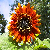

In [ ]:
img

build a dataset containing the new image

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

img_label = tf.constant([[0., 0., 0., 1., 0.]]) #sunflower

test_ds = tf.data.Dataset.from_tensor_slices((img_array, img_label))
test_ds = test_ds.batch(1)

test the obtained model

In [ ]:
test_tflite_model(path_to_tflite_model, test_ds)


Tflite model test accuracy: 1.0


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
